# Introduction
A very important aspect of supervised and semi-supervised machine learning is the quality of the labels produced by human labelers. Unfortunately, humans are not perfect and in some cases may even maliciously label things incorrectly. In this assignment, you will evaluate the impact of incorrect labels on a number of different classifiers.

We have provided a number of code snippets you can use during this assignment. Feel free to modify them or replace them.


## Dataset
The dataset you will be using is the [Adult Income dataset](https://archive.ics.uci.edu/ml/datasets/Adult). This dataset was created by Ronny Kohavi and Barry Becker and was used to predict whether a person's income is more/less than 50k USD based on census data.

### Data preprocessing
Start by loading and preprocessing the data. Remove NaN values, convert strings to categorical variables and encode the target variable (the string <=50K, >50K in column index 14).

In [1]:
import pandas as pd
import numpy as np

In [2]:
# This can be used to load the dataset
data = pd.read_csv("adult.csv", header=0, na_values='?')
data.head()

# Basic data removal: NaN values, "?" values and also empty cells
df = data.dropna()
df = df[(df != "").all(axis=1)]
df = df[(df != "?").all(axis=1)]
# Map salary to 1 if salary is larger than 50k, else to 0
df['salary'] = df['salary'].map({'<=50K': 0, '<=50K.': 0, '>50K': 1, '>50K.': 1})

# Data Exploration

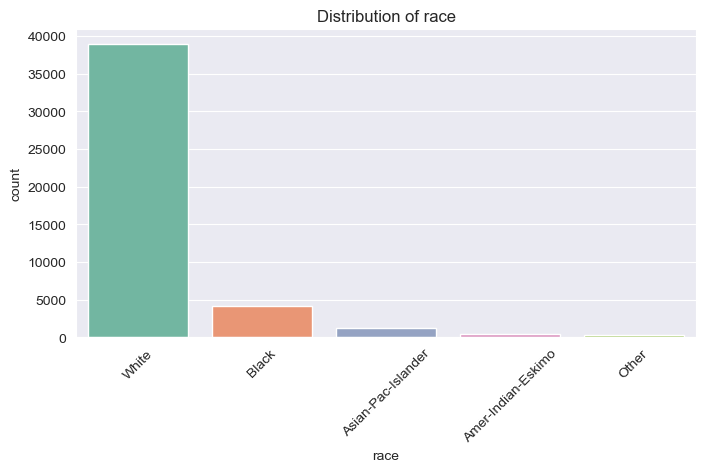

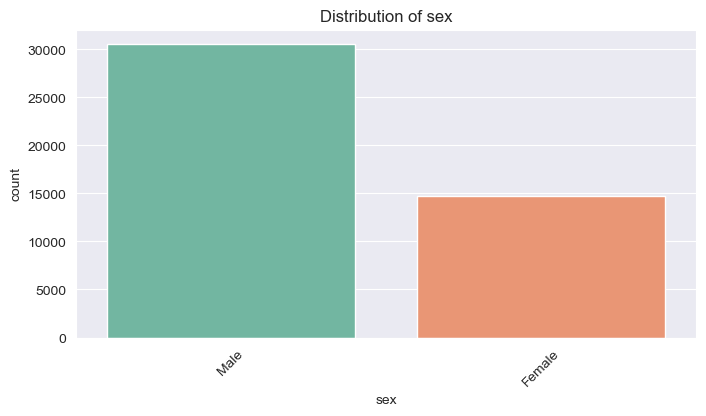

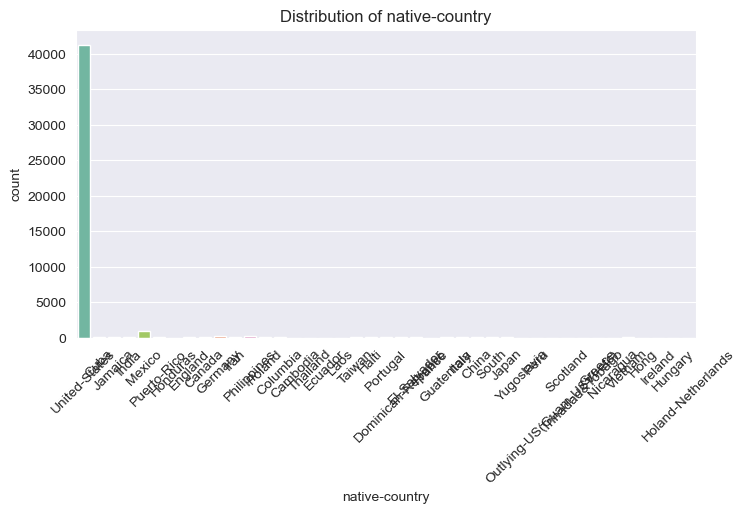

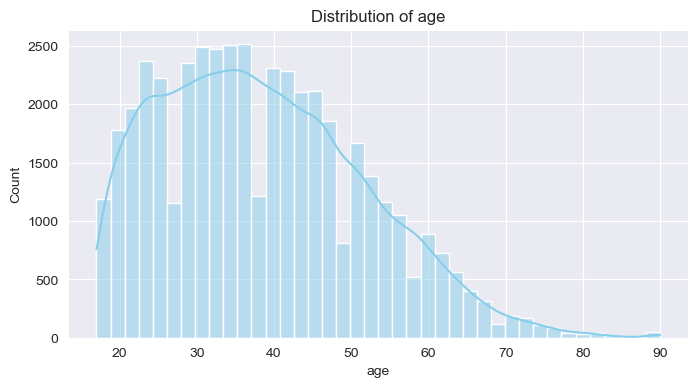

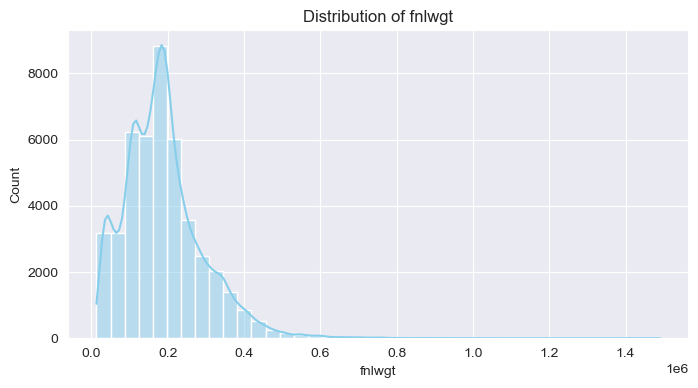

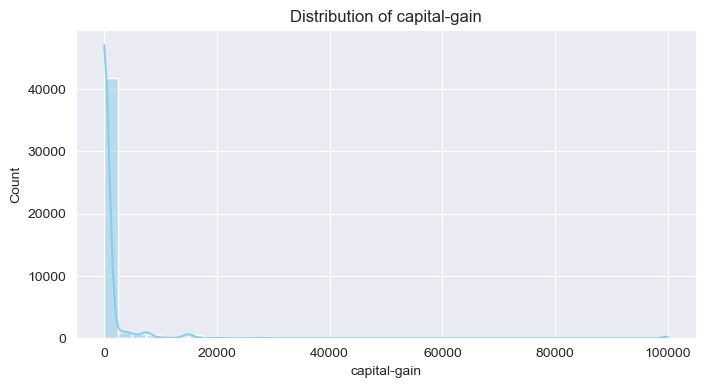

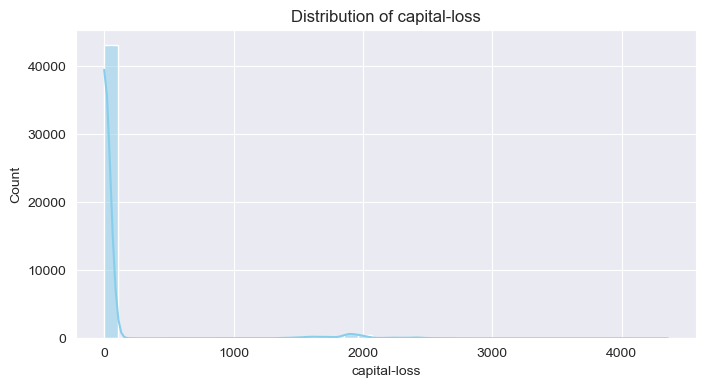

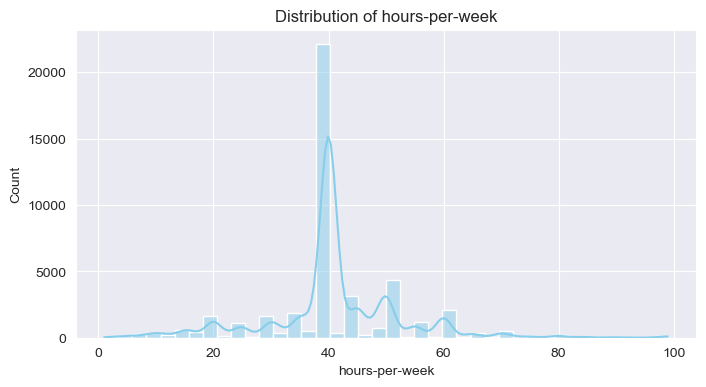

In [3]:
# Visualising distribution of: age, fnlwgt, race, sex, capital-gain, capital-loss, hours-per-week, native-country, salary, to allow for a
# better decision on which to keep/remove
import matplotlib.pyplot as plt
import seaborn as sns

categorial_cols = ['race', 'sex',  'native-country']
numerical_cols = ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']

# Loop through each column and create count plots for categorical data
for col in categorial_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, palette="Set2")
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=40, color="skyblue")
    plt.title(f'Distribution of {col}')
    plt.show()

Chi-square statistic for race: 452.30421393271354, p-value: 1.3794458063305064e-96


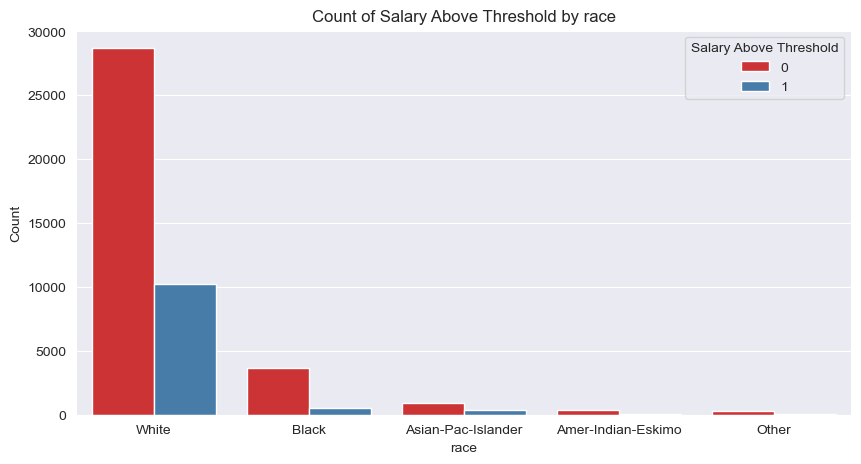

Chi-square statistic for sex: 2104.1337213723855, p-value: 0.0


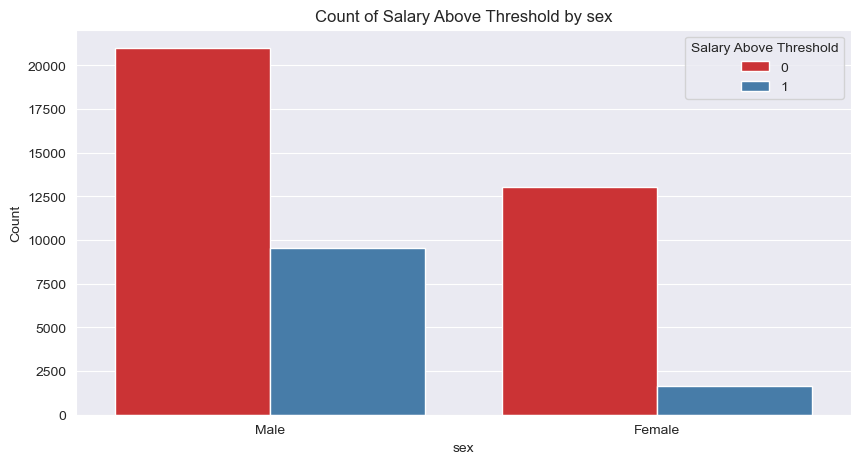

Chi-square statistic for capital-gain: 7827.99238281753, p-value: 0.0
Chi-square statistic for capital-loss: 3459.0549564013363, p-value: 0.0



Correlation between race and salary: 0.0708440841541438
Correlation between sex and salary: 0.21576045786568582
Correlation between capital-gain and salary: 0.22103380635453795
Correlation between capital-loss and salary: 0.14868698924706125


In [4]:
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder

# For race, and sex its worth to see correlation with salary to decide whether to keep or not. Because these data are usually bias inducing.
# Also, worth doing chi-square test on these features.
# For capital-gain and capital-loss also checking to see if there's correlation. Because there's not many people in the dataset that have values for this.

def contingency_chi_square_tests(col1, col2, data, visualise=True):
    contingency = pd.crosstab(data[col1], data[col2])
    chi2_value, p_value, _, _ = chi2_contingency(contingency)
    print(f"Chi-square statistic for {col1}: {chi2_value}, p-value: {p_value}")

    if visualise:
        plt.figure(figsize=(10, 5))
        sns.countplot(data=df, x=col1, hue=col2, palette='Set1')
        plt.title('Count of Salary Above Threshold by ' + col1)
        plt.xlabel(col1)
        plt.ylabel('Count')
        plt.legend(title='Salary Above Threshold')
        plt.show()

# Contingency tables for the four features we're checking
contingency_chi_square_tests('race', 'salary', df)
contingency_chi_square_tests('sex', 'salary', df)
contingency_chi_square_tests('capital-gain', 'salary', df, visualise=False)
contingency_chi_square_tests('capital-loss', 'salary', df, visualise=False)

# Doing correlation tests of these four features. First need to convert race and sex into numerical though. Then print results.
race_label_enc = LabelEncoder()
sex_label_enc = LabelEncoder()
df['race_encoded'] = race_label_enc.fit_transform(df['race'])
df['sex_encoded'] = sex_label_enc.fit_transform(df['sex'])

correlation_race = df['race_encoded'].corr(df['salary'])
correlation_sex = df['sex_encoded'].corr(df['salary'])
correlation_capital_gain = df['capital-gain'].corr(df['salary'])
correlation_capital_loss = df['capital-loss'].corr(df['salary'])

print("\n\n")
print(f"Correlation between race and salary: {correlation_race}")
print(f"Correlation between sex and salary: {correlation_sex}")
print(f"Correlation between capital-gain and salary: {correlation_capital_gain}")
print(f"Correlation between capital-loss and salary: {correlation_capital_loss}")


# Data classification
Choose at least 4 different classifiers and evaluate their performance in predicting the target variable. 

#### Preprocessing
Think about how you are going to encode the categorical variables, normalization, whether you want to use all of the features, feature dimensionality reduction, etc. Justify your choices 

A good method to apply preprocessing steps is using a Pipeline. Read more about this [here](https://machinelearningmastery.com/columntransformer-for-numerical-and-categorical-data/) and [here](https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf). 

<!-- #### Data visualization
Calculate the correlation between different features, including the target variable. Visualize the correlations in a heatmap. A good example of how to do this can be found [here](https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec). 

Select a features you think will be an important predictor of the target variable and one which is not important. Explain your answers. -->

#### Evaluation
Use a validation technique from the previous lecture to evaluate the performance of the model. Explain and justify which metrics you used to compare the different models. 

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Fresh load of data and repeating cleanup from before
data = pd.read_csv("adult.csv", header=0, na_values='?')
df = data.dropna()
df = df[(df != "").all(axis=1)]
df = df[(df != "?").all(axis=1)]
df['salary'] = df['salary'].map({'<=50K': 0, '<=50K.': 0, '>50K': 1, '>50K.': 1})

# From data exploration the final decisions for each column are as follows:
# 1. Remove: education (redundant as education-num exists), race (based on chi-square and correlation tests above), native-country (most data is US based, and if we one-hot-encode it, unnecessarily too many columns will be added)
# 2. Normalise: age, fnlwgt, capital-gain, capital-loss, hours-per-week
# 3. One-Hot-Encode: workclass, marital-status, occupation, relationship, sex. Workclass could be Label Encoded but that would be subjective.

columns_to_remove = ['education', 'race', 'native-country']
columns_to_one_hot = ['workclass', 'marital-status', 'occupation', 'relationship', 'sex']
columns_to_normalize = ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']

# df = pd.get_dummies(df, columns=columns_to_one_hot, drop_first=True)
# df = df.drop(columns=columns_to_remove)
# scaler = StandardScaler()
# df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
# df.to_csv("processed_data.csv", index=False)

ct = ColumnTransformer(
    transformers=[
        ('remove', 'drop', columns_to_remove),
        ('onehot', OneHotEncoder(), columns_to_one_hot),
        ('normalize', StandardScaler(), columns_to_normalize)
    ],
    remainder='passthrough'
)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Apply your model to data
def apply_models(X, y, models, model_names, ct):
    # Split data into X and y and get train/test split (75/25)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
    results = {}

    for i, model in enumerate(models):
        # Define pipeline
        pipeline = Pipeline(steps=[("preprocessor", ct), ("classifier", model)])
        # Fit model on training data
        pipeline.fit(X_train, y_train)
        # Evaluate fit
        y_predicted = pipeline.predict(X_test)
        acc = accuracy_score(y_test, y_predicted)
        f1_value = f1_score(y_test, y_predicted)
        report = classification_report(y_test, y_predicted, output_dict=True)

        results[model_names[i]] = {
            "accuracy": acc,
            "f1_score": f1_value,
            "classification_report": report
        }

    return results

In [8]:
# Setup data
y = df['salary']
X = df.drop(columns=['salary'])

# Initialise models
random_forest = RandomForestClassifier()
log_regr = LogisticRegression(max_iter=10000)
svm = LinearSVC(dual=False, max_iter=10000)
grad_boost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)

# Call method to train and evaluate
models = [random_forest, log_regr, svm, grad_boost]
model_names = ["random_forest", "logistic_regression", "SVM", "Gradient Booster"]
results = apply_models(X, y, models, model_names, ct)
print(results)

{'random_forest': {'accuracy': 0.854148239872634, 'f1_score': 0.6789955226786062, 'classification_report': {'0': {'precision': 0.8820644298294504, 'recall': 0.9305032925682032, 'f1-score': 0.9056366237482117, 'support': 8504.0}, '1': {'precision': 0.7468950749464668, 'recall': 0.622412562455389, 'f1-score': 0.6789955226786062, 'support': 2802.0}, 'accuracy': 0.854148239872634, 'macro avg': {'precision': 0.8144797523879586, 'recall': 0.7764579275117961, 'f1-score': 0.7923160732134089, 'support': 11306.0}, 'weighted avg': {'precision': 0.8485650018812707, 'recall': 0.854148239872634, 'f1-score': 0.8494674777021269, 'support': 11306.0}}}, 'logistic_regression': {'accuracy': 0.8462763134618786, 'f1_score': 0.6590819929384072, 'classification_report': {'0': {'precision': 0.8754716981132076, 'recall': 0.9275634995296331, 'f1-score': 0.9007651022039511, 'support': 8504.0}, '1': {'precision': 0.7317073170731707, 'recall': 0.5995717344753747, 'f1-score': 0.6590819929384072, 'support': 2802.0}, 

### Label perturbation
To evaluate the impact of faulty labels in a dataset, we will introduce some errors in the labels of our data.


#### Preparation
Start by creating a method which alters a dataset by selecting a percentage of rows randomly and swaps labels from a 0->1 and 1->0. 


In [9]:
"""Given a label vector, create a new copy where a random fraction of the labels have been flipped."""
def perturbate(y: np.ndarray, fraction: float) -> np.ndarray:
    if fraction == 0:
        return y

    # Create a copy of the original label array
    copy = y.copy()

    # Calculate the number of labels to flip
    n_flip = int(fraction * len(copy))

    # Randomly select indices to flip
    flip_indices = np.random.choice(len(copy), size=n_flip, replace=False)

    # Flip the selected labels (0 -> 1, 1 -> 0)
    copy[flip_indices] = 1 - copy[flip_indices]

    return copy

#### Analysis
Create a number of new datasets with perturbed labels, for fractions ranging from `0` to `0.5` in increments of `0.1`.

Perform the same experiment you did before, which compared the performances of different models except with the new datasets. Repeat your experiment at least 5x for each model and perturbation level and calculate the mean and variance of the scores. Visualize the change in score for different perturbation levels for all of the models in a single plot. 

State your observations. Is there a change in the performance of the models? Are there some classifiers which are impacted more/less than other classifiers and why is this the case?

In [36]:
perturbed_label_sets = []
for i in [0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    perturbed_label_sets.append(perturbate(y.to_numpy(), i))

perturbed_label_sets = np.array(perturbed_label_sets)

# Run our experiment 6 times for each level
experiment_results = []
for i in range(6):
    perturbed_y = perturbed_label_sets[i]
    results = []
    for j in range(5):
        res = apply_models(X, perturbed_y, models, model_names, ct)
        results.append(res)
    experiment_results.append(results)

In [37]:
dict = {}
perturbation_names = ["0.0", "0.1", "0.2", "0.3", "0.4" "0.5"]
for model_name in model_names:
    dict[model_name] = {}


for name_idx, current_perturbation in enumerate(experiment_results):
    current_perturbation_name = perturbation_names[name_idx]

    # In this current_perturbation array I have 5 dictionaries, each dictionary is the 'result' dictionary from the apply_models methods
    # Loop over each of the 4 model names
    for model_name in model_names:
        accuracies = []
        f1_scores = []

        # Across the 5 experiments done for this perturbation, find the accuracy and f1 score
        for i in range(5):
            accuracies.append(current_perturbation[i][model_name]["accuracy"])
            f1_scores.append(current_perturbation[i][model_name]["f1_score"])

        # Compute the means and variances and add them to our dict
        accuracies = np.array(accuracies)
        mean_acc = np.mean(accuracies)
        var_acc = np.var(accuracies)

        f1_scores = np.array(f1_scores)
        mean_f1 = np.mean(f1_scores)
        var_f1 = np.var(f1_scores)

        dict[model_name][current_perturbation_name] = {}
        dict[model_name][current_perturbation_name]["mean_acc"] = mean_acc
        dict[model_name][current_perturbation_name]["var_acc"] = var_acc
        dict[model_name][current_perturbation_name]["mean_f1"] = mean_f1
        dict[model_name][current_perturbation_name]["var_f1"] = var_f1


In [ ]:
print(dict)

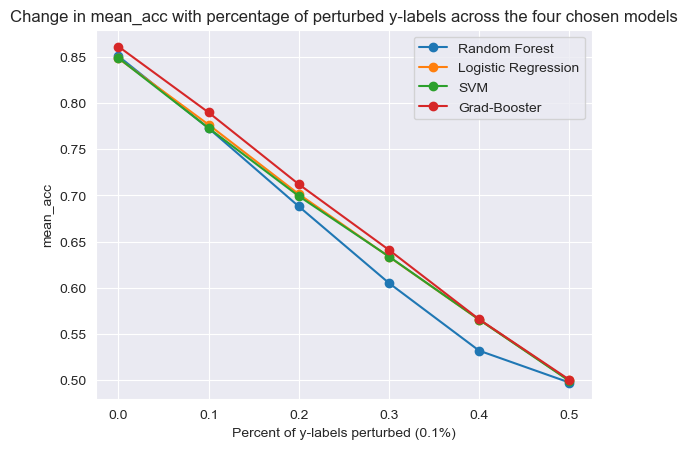

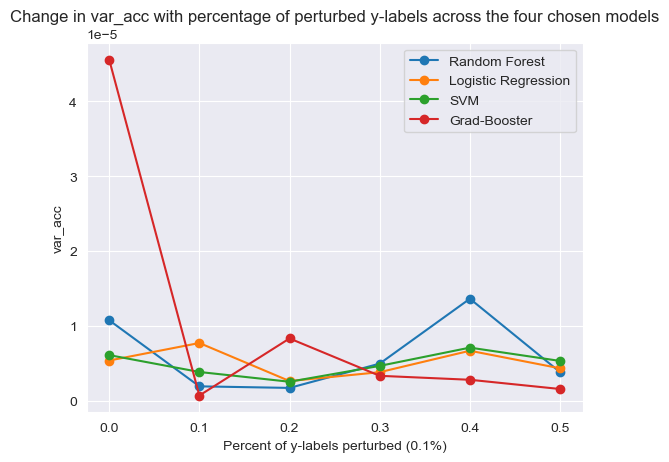

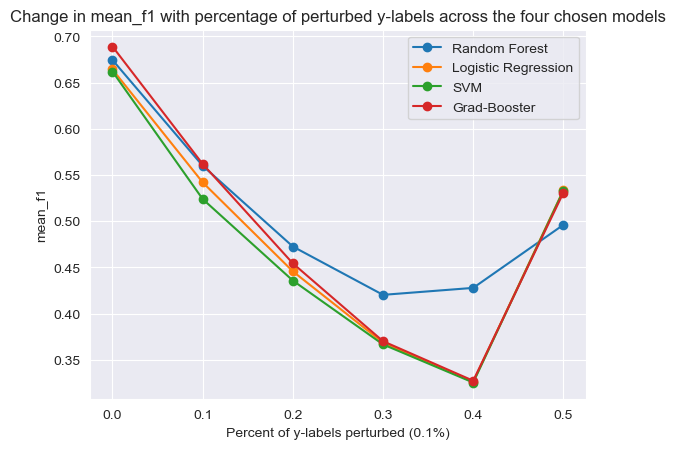

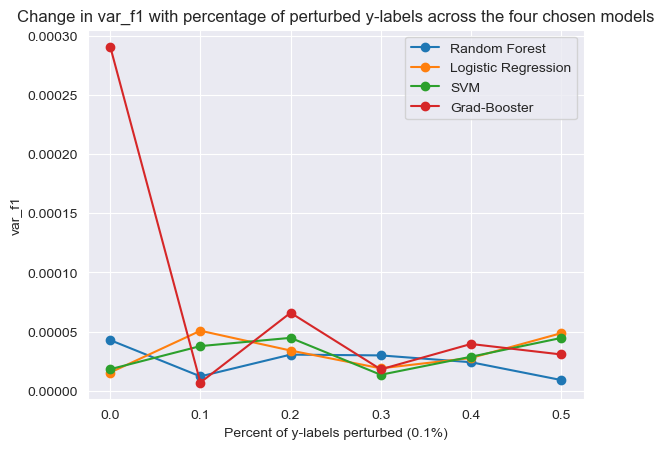

In [12]:
import matplotlib.pyplot as plt

# use the above dict or just copy it from the cell output
data = {
    'random_forest': {
        '0.0': {'mean_acc': 0.850663364585176, 'var_acc': 1.0779058435508168e-05, 'mean_f1': 0.6745150622371725, 'var_f1': 4.2786319678102166e-05},
        '0.1': {'mean_acc': 0.7726339996462055, 'var_acc': 1.9607960331212577e-06, 'mean_f1': 0.5600180987145531, 'var_f1': 1.2116287255154797e-05},
        '0.2': {'mean_acc': 0.6880771271891032, 'var_acc': 1.7511354295158144e-06, 'mean_f1': 0.4725795833009965, 'var_f1': 3.0515977652873996e-05},
        '0.3': {'mean_acc': 0.6051477091809658, 'var_acc': 4.9924257760000484e-06, 'mean_f1': 0.42028628830287856, 'var_f1': 2.9855172016711396e-05},
        '0.4': {'mean_acc': 0.5319830178666195, 'var_acc': 1.3648592368435312e-05, 'mean_f1': 0.42783124334751416, 'var_f1': 2.4096517115953002e-05},
        '0.5': {'mean_acc': 0.49752343888200956, 'var_acc': 3.8552516961464565e-06, 'mean_f1': 0.49609973433320376, 'var_f1': 9.045271080261405e-06}
    },
    'logistic_regression': {
        '0.0': {'mean_acc': 0.8482221829117282, 'var_acc': 5.404236752633861e-06, 'mean_f1': 0.6642259399929304, 'var_f1': 1.5376774131171858e-05},
        '0.1': {'mean_acc': 0.7765257385459048, 'var_acc': 7.743673577340858e-06, 'mean_f1': 0.5420379855865222, 'var_f1': 5.07118701356174e-05},
        '0.2': {'mean_acc': 0.7013797983371661, 'var_acc': 2.6642542971583513e-06, 'mean_f1': 0.44570892787965677, 'var_f1': 3.397682390563077e-05},
        '0.3': {'mean_acc': 0.6336104723155846, 'var_acc': 3.850870728309899e-06, 'mean_f1': 0.3685328314735121, 'var_f1': 1.8926606908129507e-05},
        '0.4': {'mean_acc': 0.5655934901822042, 'var_acc': 6.711016873015794e-06, 'mean_f1': 0.3262344101413093, 'var_f1': 2.768501451824968e-05},
        '0.5': {'mean_acc': 0.49973465416592966, 'var_acc': 4.365321522828163e-06, 'mean_f1': 0.5336554420663222, 'var_f1': 4.86149606694237e-05}
    },
    'SVM': {
        '0.0': {'mean_acc': 0.8486821156907837, 'var_acc': 6.12834815075749e-06, 'mean_f1': 0.6620178649921415, 'var_f1': 1.8178421463570093e-05},
        '0.1': {'mean_acc': 0.7728285865911906, 'var_acc': 3.875904830233002e-06, 'mean_f1': 0.5239848918303407, 'var_f1': 3.77272335514664e-05},
        '0.2': {'mean_acc': 0.6992393419423315, 'var_acc': 2.5741315302354462e-06, 'mean_f1': 0.4357394699165799, 'var_f1': 4.469562335208212e-05},
        '0.3': {'mean_acc': 0.6338227489828409, 'var_acc': 4.69076484782767e-06, 'mean_f1': 0.3666255879971217, 'var_f1': 1.347869948978629e-05},
        '0.4': {'mean_acc': 0.5655581107376614, 'var_acc': 7.126582964938144e-06, 'mean_f1': 0.32540177487387817, 'var_f1': 2.8725461519248183e-05},
        '0.5': {'mean_acc': 0.4992570316646029, 'var_acc': 5.3497875809512335e-06, 'mean_f1': 0.5332402866887701, 'var_f1': 4.4589763741300735e-05}
    },
    'Gradient Booster': {
        '0.0': {'mean_acc': 0.8611003007252787, 'var_acc': 4.556394305755691e-05, 'mean_f1': 0.6890940267095218, 'var_f1': 0.0002909976855566734},
        '0.1': {'mean_acc': 0.789739961082611, 'var_acc': 7.366284490851819e-07, 'mean_f1': 0.5619686926545665, 'var_f1': 6.9353572229064775e-06},
        '0.2': {'mean_acc': 0.7120467008667963, 'var_acc': 8.350750548974236e-06, 'mean_f1': 0.4543389784176517, 'var_f1': 6.589167080630133e-05},
        '0.3': {'mean_acc': 0.6410047762250134, 'var_acc': 3.3652091510031067e-06, 'mean_f1': 0.3701109062280361, 'var_f1': 1.806822759149987e-05},
        '0.4': {'mean_acc': 0.56592959490536, 'var_acc': 2.8369896004272935e-06, 'mean_f1': 0.32731054242641305, 'var_f1': 3.9509730686928536e-05},
        '0.5': {'mean_acc': 0.5005306916681408, 'var_acc': 1.6053117858142055e-06, 'mean_f1': 0.5309233631348643, 'var_f1': 3.0664687867147875e-05}
    }
}

# x-values
x_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

# Metrics to plot
metrics = ['mean_acc', 'var_acc', 'mean_f1', 'var_f1']

# Extracting y-values for each model and each metric
for metric in metrics:
    y_random_forest = [data['random_forest'][str(i)][metric] for i in x_values]
    y_logistic_regression = [data['logistic_regression'][str(i)][metric] for i in x_values]
    y_svm = [data['SVM'][str(i)][metric] for i in x_values]
    y_gradient_booster = [data['Gradient Booster'][str(i)][metric] for i in x_values]

    # Plotting the data for each metric
    plt.figure()
    plt.plot(x_values, y_random_forest, label='Random Forest', marker='o')
    plt.plot(x_values, y_logistic_regression, label='Logistic Regression', marker='o')
    plt.plot(x_values, y_svm, label='SVM', marker='o')
    plt.plot(x_values, y_gradient_booster, label="Grad-Booster", marker='o')

    # Adding labels and title
    plt.xlabel('Percent of y-labels perturbed (0.1%)')
    plt.ylabel(metric)
    plt.title(f'Change in {metric} with percentage of perturbed y-labels across the four chosen models')

    # Adding a legend
    plt.legend()

    # Display the plot
    plt.show()

Observations + explanations: max. 400 words

Examining the first graph, which plots the mean accuracy across the five experiments, we observe that all four models start with high accuracy (~85%) when there are no faulty labels. As the percentage of perturbed labels increases, we see a roughly linear decrease in accuracy for all models. When half of the data is perturbed, all models reach a mean accuracy of about 50%. Notably, the random forest model appears more affected by the perturbations. This could be because some of its decision trees might receive more of the perturbed data, performing worse and consequently lowering the overall performance. 

Examining the third graph, which plots the mean f1-score across the five experiments, we see that as we increase the label noise from 0% to 40%, the F1 scores drop for all models in (approximate) linear fashion; because the relationship between features and the target label is getting increasingly corrupted. However, when reaching 50% perturbation, a sudden increase in F1 scores is seen across all models. A reason for this could be that the data is so randomized that models might essentially revert to treating both classes as near-equal probabilities. Because F1 is a harmonic mean of precision and recall, this class balance might lead to an improvement in the metric. The models may also be overfitting to the noise at this point. Additionally, as the distribution of label errors becomes highly symmetric or random, models like random forest that rely more on the structure of the input features, seem to maintain some ability to correctly classify parts of the data, and therefore are less affected by the perturbed labels. 

We see little to none variance in the experiments (second and fourth graph above), both the mean accuracies and the f1-scores have variance in order of 1e-5 magnitude. Suggesting that the seen metric scores and patterns are somewhat reliable across multiple attempts.

#### Discussion

1)  Discuss how you could reduce the impact of wrongly labeled data or correct wrong labels. <br />
    max. 400 words

There are several approaches to deal with label noise. The first approach could be to integrate human review; having experts manually review and correct labels. This can be time-consuming but effective for smaller datasets. Another approach could be to smartly detect noisy labels. After training a model, samples where the model's confidence is very low or where predictions frequently mismatch the given labels could be flagged for review. When using ensemble models like the gradient booster, high quantity of disagreements between the models in the ensemble could indicate label perturbations.  After these potential perturbed labels are detected, they can be pruned or fixed. Additionally, unsupervised anomaly detection methods on the dataset can also be used to detect potentially mislabeled samples, as they might appear as outliers based on the feature values. 

The above approaches involve identifying and fixing the noisy labels or reducing their negative effects directly, however, another way is to make the model training process itself more robust. Examples include changing the used loss function. Mean absolute error could be used instead of cross-entropy loss, so that less importance is given to highly confident predictions. Early stopping could also be adopted to avoid overfitting to noise, for the same reasons regularization can be added. A risky but interesting approach could be bootstrap learning. After training the model and predicting on the training data, you combine the original and predicted labels to create new training labels. This approach could work well when base model is reasonably accurate and the label noise is not significantly high as was during our experiments.

    Authors: Youri Arkesteijn, Tim van der Horst and Kevin Chong.


## Machine Learning Workflow

From part 1, you will have gone through the entire machine learning workflow which are they following steps:

1) Data Loading
2) Data Pre-processing
3) Machine Learning Model Training
4) Machine Learning Model Testing

You can see these tasks are very sequential, and need to be done in a serial fashion. 

As a small perturbation in the actions performed in each of the steps may have a detrimental knock-on effect in the task that comes afterwards.

In the final part of Part 1, you will have experienced the effects of performing perturbations to the machine learning model training aspect and the reaction of the machine learning model testing section.

    ## Part 2 Data Discovery

Now we have a some datasets that are related to each other.

**Altogether they are the same as the adult dataset used in the part 1 of the assignment.**

In this scenario, one can see the utility of the subsets of data can impact the outcome of the task from the previous section.

Because the data is split up, we want to be able to re-construct the data through data discovery.

As data discovery will allow you to be able to find relations that can be used to reconstruct the entire dataset.

Implement a method of your choice to perform the data discovery to be able to recover the entire dataset from part 1 of the assignment.

In [3]:
from itertools import combinations
data_01 = pd.read_csv("data_adult_discovery/data_adult_0_1.csv", header=0, na_values='?')

data_02 = pd.read_csv("data_adult_discovery/data_adult_0_2.csv", header=0, na_values='?')

data_03 = pd.read_csv("data_adult_discovery/data_adult_1_1.csv", header=0, na_values='?')

data_04 = pd.read_csv("data_adult_discovery/data_adult_1_2.csv", header=0, na_values='?')

data_05 = pd.read_csv("data_adult_discovery/data_adult_2_1.csv", header=0, na_values='?')

data_06 = pd.read_csv("data_adult_discovery/data_adult_2_2.csv", header=0, na_values='?')

datasets = [data_01, data_02, data_03, data_04, data_05, data_06]

def jaccard_similarity(set1, set2):
    c_inter = len(set1.intersection(set2))
    c_union = len(set1.union(set2))
    return c_inter / c_union

def jaccard_similarity_on_column_names(dataset1, dataset2):
    col_names1 = set(dataset1.columns)
    col_names2 = set(dataset2.columns)
    return jaccard_similarity(col_names1, col_names2)

def max_jaccard_similarity_on_column_values(dataset1, dataset2):
    max_jacc = 0
    max_col1_name = ''
    max_col2_name = ''
    for column1_name in dataset1.columns:
        for column2_name in dataset2.columns:
            column1 = dataset1.loc[:,column1_name]
            column2 = dataset2.loc[:,column2_name]
            similarity = jaccard_similarity(set(column1), set(column2))
            if similarity > max_jacc:
                max_jacc = similarity
                max_col1_name = column1_name
                max_col2_name = column2_name

    return max_jacc

def set_containment(set1, set2):
    c_inter = len(set1.intersection(set2))
    c_set1 = len(set1)
    return c_inter / c_set1

def set_containment_on_column_names(dataset1, dataset2):
    col_names1 = set(dataset1.columns)
    col_names2 = set(dataset2.columns)
    return set_containment(col_names1, col_names2)

# Stronger indication for joinable columns, method currently doesn't return column names but is possible
def max_set_containment_on_column_values(dataset1, dataset2):
    max_setcon = 0
    max_col1_name = ''
    max_col2_name = ''
    for column1_name in dataset1.columns:
        for column2_name in dataset2.columns:
            column1 = dataset1.loc[:,column1_name]
            column2 = dataset2.loc[:,column2_name]
            similarity = set_containment(set(column1), set(column2))
            if similarity > max_setcon:
                max_setcon = similarity
                max_col1_name = column1_name
                max_col2_name = column2_name

    # Added this because set containment is order dependent, unsure if actually needed
    for column1_name in dataset2.columns:
        for column2_name in dataset1.columns:
            column1 = dataset2.loc[:,column1_name]
            column2 = dataset1.loc[:,column2_name]
            similarity = set_containment(set(column1), set(column2))
            if similarity > max_setcon:
                max_setcon = similarity
                max_col1_name = column1_name
                max_col2_name = column2_name

    return max_setcon

# Not doing set overlap because apparently is less reliable


def discovery_algorithm(datasets, similarity_threshold):
    """Function should be able to perform data discovery to find related datasets
    Possible Input: List of datasets
    Output: List of pairs of related datasets
    """
    results = []

    # Get all dataset pairs
    dataset_pairs = list(combinations(enumerate(datasets), 2))

    for (index1, dataset1), (index2, dataset2) in dataset_pairs:

        similarity = max_set_containment_on_column_values(dataset1, dataset2)

        if similarity >= similarity_threshold:
            results.append((index1, index2, similarity))

    return results

result = discovery_algorithm(datasets, similarity_threshold=0.5)
print(result)


[(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (0, 4, 1.0), (0, 5, 1.0), (1, 2, 1.0), (1, 3, 1.0), (1, 4, 1.0), (1, 5, 1.0), (2, 3, 1.0), (2, 4, 1.0), (2, 5, 1.0), (3, 4, 0.9956458635703919), (3, 5, 1.0), (4, 5, 1.0)]


In [64]:
import random

# Combine the related datasets
def combineDatasets(datasets, related_pairs):
    merged_datasets = []

    for (index1, index2, common_columns, similarity_score) in related_pairs:
        #Merging on the common columns
        merged_data = pd.merge(datasets[index1], datasets[index2], on=list(common_columns), how='outer')
        merged_data.fillna(0, inplace=True)

        merged_datasets.append(merged_data)

    return merged_datasets

# merged_datasets = combineDatasets(datasets, result)

# merged_datasets[5].to_csv('output.csv', index=False)
# merged_datasets[2].head()


# Selecting the testing data
def sampleTestingDataset():
    # This can be used to load the dataset
    fullDatasets = pd.read_csv("adult.csv", header=None, na_values='?')

    test_df = fullDatasets.sample(frac=0.2)

    return test_df

# df = sampleTestingDataset()
# df.head()

# Combine the datasets through random combinations of the datasets
def randomCombinations():

    numbers = random.sample(range(6), 2)

    dataset1 = datasets[numbers[0]]
    dataset2 = datasets[numbers[1]]

    col_names1 = set(dataset1.columns)
    col_names2 = set(dataset2.columns)

    common_columns = col_names1.intersection(col_names2)

    merged_data = pd.merge(dataset1, dataset2, on=list(common_columns), how='outer')
    merged_data.fillna(0, inplace=True)

    return merged_data


def merge_All_Datasets(datasets):
    
    # Combine all datasets into one 
    common_columns1 = datasets[0].columns.intersection(datasets[1].columns)
    merged_df1 = pd.merge(datasets[0], datasets[1], on=list(common_columns1), how='outer')
    merged_df1.fillna(0, inplace=True)
    
    common_columns2 = datasets[2].columns.intersection(datasets[3].columns)
    merged_df2 = pd.merge(datasets[2], datasets[3], on=list(common_columns2), how='outer')
    merged_df2.fillna(0, inplace=True)
    
    common_columns3 = datasets[4].columns.intersection(datasets[5].columns)
    merged_df3 = pd.merge(datasets[4], datasets[5], on=list(common_columns3), how='outer')
    merged_df3.fillna(0, inplace=True)
    
    frames = [merged_df1, merged_df2, merged_df3]
    
    all_data = pd.concat(frames)
                               
    return all_data
    
def remove_unrelated_columns(datasets):
    # Remove the column which is less related
    columns = datasets.columns
    n = len(columns)
    
    related_columns = []
    for i in range(n):
        for j in range(i+1, n):
            col1 = datasets.iloc[:, i]
            col2 = datasets.iloc[:, j]
            
            similarity = set_containment(set(col1), set(col2))
            if similarity > 0.5:
                print("Similar column found: "+ str(i) +" " + str(j))
                if columns[i] not in related_columns:
                    related_columns.append(columns[i])
                if columns[j] not in related_columns:
                    related_columns.append(columns[j])
                
    
    for i in range(len(columns)):
        if columns[i] not in related_columns:
            datasets.drop(columns=columns[i], inplace=True)
    
    return datasets
    
    
ds = [data_01,data_02,data_03,data_04,data_05,data_06]
ds_combined = merge_All_Datasets(ds)
ds_combined.head()
# newds = remove_unrelated_columns(ds_combined)
# newds.head()


,Unnamed: 0,hours-per-week,occupation,capital-gain,relationship,education-num,sex,workclass,capital-loss,first_name,last_names,age,fnlwgt,education,marital-status,race,native-country,salary
0,0,20,Other-service,0,Not-in-family,9.0,Male,Private,0,Michelle,Spencer,18,423024,HS-grad,Never-married,White,United-States,<=50K
1,1,20,Sales,0,Own-child,8.0,Female,Private,0,Lisa,Hall,17,178953,12th,Never-married,White,United-States,<=50K
2,2,40,Handlers-cleaners,0,Other-relative,9.0,Male,Local-gov,0,Jason,Sanders,25,348986,HS-grad,Never-married,Black,United-States,<=50K
3,3,30,Sales,0,Own-child,10.0,Female,Private,0,Zachary,Bowen,20,218215,Some-college,Never-married,White,United-States,<=50K
4,4,56,Machine-op-inspct,0,Unmarried,9.0,Male,Private,0,Joshua,Coleman,47,244025,HS-grad,Never-married,Amer-Indian-Eskimo,Puerto-Rico,<=50K


In [22]:
## Do some testing using different degrees of relations on the downstream task.
##

#fullDatasets = pd.read_csv("adult.csv", header=None, na_values='?')
#merged_dataset.compare(fullDatasets)


### Evaluation

Following the same workflow as Part 1 of the assignment, you will need to perform the steps once again.
This means that with the difference in setting, there has now been a change in the data loading portion of the workflow. 

<!-- While performing data discovery, one can check how having more data of different relations can effect the outcome of the downstream task. -->

As you perform the act of data discovery you will be piecing the data back together one by one by finding the relation between the datasets.

As you piece the data back together, the entire dataset will be available in varying portions.

Then using the different portions of available data, fit the models that were used previously, and examine the results when testing on the appropriate data from the testing samples.

*The dataset from part 1 can be treated as the groundtruth, so you can try and random sample from that dataset to produce the testing samples that can be used in this part.* 

***

One can also evaluate on the effect of incorrectness of data discovery.

Suppose what you have done for data discovery is correct, this means the relations that are found are correct.

What if you perform a perturbation on the relations between the files? 

This would mean the dataset will be incorrectly joined, do you think there will be an impact on the outcome of the model that will be trained and then tested on the groudtruth dataset?

What would the effect be on the downstream tasks as mentioned in the machine learning workflow such as data pre-processing, machine learning model training and testing?

This can be evaluated in the same way as above.

In [ ]:
## Do some testing on performing various degrees of incorrect data discovery.
##

## Discussions

1)  Discuss the different effects of the results of the data discovery results on various downstream tasks in the machine learning workflow.
    As stated previously, this is effecting the data loading portion of the ML workflow.

2)  Discuss also what aspects need to be considered when performing data discovery and evaluating the results of data discovery.

Max. 400 words

The perturbations that performed for part 1 and 2 are all data quality issues.

3) Discuss on the effects of data quality and how you may attempt to identify and solve these issues?

<!-- For the set of considerations that you have outlined for the choice of data discovery methods, choose one and identify under this new constraint, how would you identify and resolve this problem? -->

Max 400 words

There are some data quality issues are solved in part 1. The first issue is missing values which are represented by question mark or null value in columns like workclass, occupation and native-country. They could be treated as valid data which lead to incorrect conclusions. To deal with the missing values, the first approach is finding the instances contain missing values and remove them. Another approach is imputation which replaces missing values with estimated value. The second issue is the target label is inconsistent in column salary. It will confuse models and lead to wrong predictions. We use binary data (0,1) to indicate whether salary it exceeds 50K. Another issue is the data set contains redundant feature: education and education-num which may not provide additional value to models and lead to multicollinearity. To address this problem, the column named education was removed from the dataset. Some of the numerical features have skewed distributions like age, fnlwgt, capital-gain, capital-loss, hours-per-week. Due to these features may significantly influence the performance of models, we decided to apply normalization to reduce the impact.

Apart from that, feature named native country contains 41 different categories, but most of instances in the dataset are from the United States and it does not show a relationship with the salary. Since this feature may act as noise, it was removed from the datasets. In addition, the chi-square and correlation tests were applied to salary and race. The results show race has a weak correlation with salary which may not help improve the performance, so the feature named race was also removed.
